# Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/deepfashion2_trousers_subset.zip

In [ ]:
!cp -r /content/content/deepfashion2_trousers_subset /content

In [ ]:
!rm -r /content/content/

In [ ]:
!unzip -q /content/drive/MyDrive/output_trousers_keypoints_101.zip

In [ ]:
!cp -r /content/content/deepfashion2_trousers_subset/output_trousers_keypoints_101 /content/deepfashion2_trousers_subset

In [ ]:
!rm -r /content/content/

In [ ]:
import os

file_path = "/content/deepfashion2_trousers_subset/Complete_Trousers_Dataset/coco_format/validation_coco.json"

if os.path.exists(file_path):
    os.remove(file_path)
    print("File deleted successfully.")
else:
    print("File does not exist.")


File deleted successfully.


In [ ]:
import json

# Load and re-save JSON to fix format
with open("/content/validation_coco.json", "r") as f:
    data = json.load(f)

# Save it cleanly
with open("/content/cleaned_validation_coco.json", "w") as f:
    json.dump(data, f, indent=2)


In [ ]:
!cp -r /content/cleaned_validation_coco.json /content/deepfashion2_trousers_subset/Complete_Trousers_Dataset/coco_format

# Install Detectron2

In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-2ijqfz7a
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-2ijqfz7a
  Resolved https://github.com/facebookresearch/detectron2.git to commit 18f69583391e5040043ca4f4bebd2c60f0ebfde0
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 40.6 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp311-cp311-linux_x86_64.whl size=6434849 sha256=629991a5ea6daf4ae38a884ba2914709c30f98c86a75c7d945f2fd713df02cef
  Stored in directory: /tmp/pip-ephem-wheel-cache-t_s2tb5o/wheels/17/d9/40/60db98e485aa9455d

# Register Dataset

In [ ]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog

# Dataset paths
train_json = "/content/deepfashion2_trousers_subset/Complete_Trousers_Dataset/coco_format/train_coco.json"
train_img_dir = "/content/deepfashion2_trousers_subset/Complete_Trousers_Dataset/train/image"

val_json = "/content/deepfashion2_trousers_subset/Complete_Trousers_Dataset/coco_format/validation_coco.json"
val_img_dir = "/content/deepfashion2_trousers_subset/Complete_Trousers_Dataset/validation/image"

# Register COCO-format datasets
register_coco_instances("trousers_train", {}, train_json, train_img_dir)
register_coco_instances("trousers_val", {}, val_json, val_img_dir)

# Define keypoint info
keypoint_names = [
    "left_hip", "right_hip", "left_knee", "right_knee",
    "left_ankle", "right_ankle", "left_pocket", "right_pocket",
    "waist_center", "crotch", "left_thigh", "right_thigh",
    "left_hem", "right_hem"
]

keypoint_flip_map = [
    ("left_hip", "right_hip"),
    ("left_knee", "right_knee"),
    ("left_ankle", "right_ankle"),
    ("left_pocket", "right_pocket"),
    ("left_thigh", "right_thigh"),
    ("left_hem", "right_hem")
]

# Assign metadata
for d in ["trousers_train", "trousers_val"]:
    meta = MetadataCatalog.get(d)
    meta.thing_classes = ["trousers"]
    meta.keypoint_names = keypoint_names
    meta.keypoint_flip_map = keypoint_flip_map
    meta.evaluator_type = "coco"


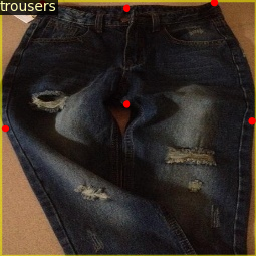

In [ ]:
import random
import cv2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from google.colab.patches import cv2_imshow # Import cv2_imshow

# Load a sample
dataset_dicts = DatasetCatalog.get("trousers_train")
metadata = MetadataCatalog.get("trousers_train")

# Pick one random image to display
sample = random.choice(dataset_dicts)

# Load the image
img = cv2.imread(sample["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1.0)
out = visualizer.draw_dataset_dict(sample)
# Use cv2_imshow instead of cv2.imshow
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("trousers_train",)
cfg.DATASETS.TEST = ("trousers_val",)
cfg.DATALOADER.NUM_WORKERS = 2

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml")

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 14

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 2999
cfg.SOLVER.STEPS = []

cfg.TEST.EVAL_PERIOD = 0

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 100

cfg.OUTPUT_DIR = "/content/deepfashion2_trousers_subset/output_trousers_keypoints_101"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
import os

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/18 10:13:18 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.keypoint_head.score_lowres.{bias, weight}


[07/18 10:13:21 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.11/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)


[07/18 10:13:42 d2.utils.events]:  eta: 0:49:42  iter: 19  total_loss: 8.729  loss_cls: 0.2386  loss_box_reg: 0.2844  loss_keypoint: 8.139  loss_rpn_cls: 0.01808  loss_rpn_loc: 0.02739    time: 1.0309  last_time: 0.9203  data_time: 0.0390  last_data_time: 0.0205   lr: 4.9953e-06  max_mem: 6226M
[07/18 10:14:03 d2.utils.events]:  eta: 0:50:14  iter: 39  total_loss: 8.655  loss_cls: 0.1969  loss_box_reg: 0.2639  loss_keypoint: 8.152  loss_rpn_cls: 0.01417  loss_rpn_loc: 0.02402    time: 1.0459  last_time: 0.9981  data_time: 0.0253  last_data_time: 0.0247   lr: 9.9902e-06  max_mem: 6226M
[07/18 10:14:24 d2.utils.events]:  eta: 0:49:53  iter: 59  total_loss: 8.723  loss_cls: 0.2739  loss_box_reg: 0.2648  loss_keypoint: 8.136  loss_rpn_cls: 0.0162  loss_rpn_loc: 0.0236    time: 1.0436  last_time: 1.1013  data_time: 0.0232  last_data_time: 0.0169   lr: 1.4985e-05  max_mem: 6226M
[07/18 10:14:45 d2.utils.events]:  eta: 0:50:01  iter: 79  total_loss: 8.611  loss_cls: 0.2039  loss_box_reg: 0.23

In [ ]:
!zip -r /content/output_trousers_keypoints_101.zip /content/deepfashion2_trousers_subset/output_trousers_keypoints_101

In [ ]:
!cp /content/output_trousers_keypoints_101.zip /content/drive/MyDrive/

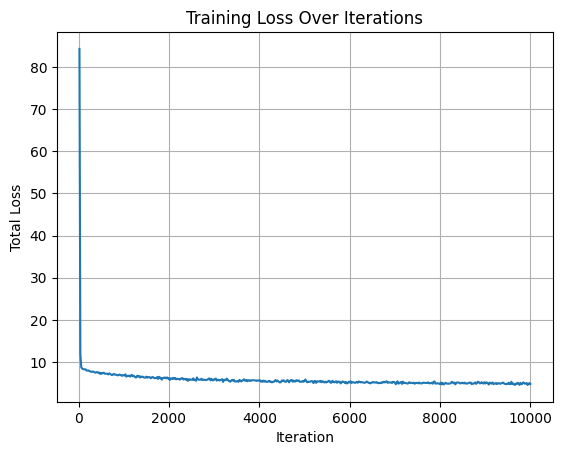

In [ ]:
import json
import matplotlib.pyplot as plt

metrics_path = "/content/deepfashion2_trousers_subset/output_trousers_keypoints/metrics.json"

losses = []
iterations = []

with open(metrics_path, 'r') as f:
    for line in f:
        try:
            data = json.loads(line)
            if "total_loss" in data:
                losses.append(data["total_loss"])
                iterations.append(data["iteration"])
        except:
            continue  # skip malformed lines if any

plt.plot(iterations, losses)
plt.title("Training Loss Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Total Loss")
plt.grid(True)
plt.show()

In [ ]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("trousers_train",)
cfg.DATASETS.TEST = ("trousers_val",)
cfg.DATALOADER.NUM_WORKERS = 2

# IMPORTANT: Use the last saved checkpoint
cfg.MODEL.WEIGHTS = os.path.join("/content/deepfashion2_trousers_subset/output_trousers_keypoints_101", "model_final.pth")

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 14

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 10000  # extend to 10000
cfg.SOLVER.STEPS = []

cfg.TEST.EVAL_PERIOD = 0  # or 500 if you fix evaluator
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 100

cfg.OUTPUT_DIR = "/content/deepfashion2_trousers_subset/output_trousers_keypoints_101"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
from detectron2.engine import DefaultTrainer

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[07/18 15:07:55 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.11/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.11/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing a

[07/18 15:08:02 d2.utils.events]:  iter: 2999  total_loss: 3.975  loss_cls: 0.0141  loss_box_reg: 0.006584  loss_keypoint: 3.94  loss_rpn_cls: 0.001603  loss_rpn_loc: 0.01238    data_time: 0.2291  last_data_time: 0.2291   lr: 0.00025  max_mem: 4123M
[07/18 15:08:31 d2.utils.events]:  eta: 1:55:43  iter: 3019  total_loss: 3.757  loss_cls: 0.005274  loss_box_reg: 0.009492  loss_keypoint: 3.726  loss_rpn_cls: 0.0008895  loss_rpn_loc: 0.01081    time: 0.9532  last_time: 1.0090  data_time: 0.0230  last_data_time: 0.0269   lr: 0.00025  max_mem: 4412M
[07/18 15:08:50 d2.utils.events]:  eta: 1:55:32  iter: 3039  total_loss: 4.241  loss_cls: 0.003418  loss_box_reg: 0.009443  loss_keypoint: 4.218  loss_rpn_cls: 0.001354  loss_rpn_loc: 0.01122    time: 0.9531  last_time: 0.8228  data_time: 0.0189  last_data_time: 0.0256   lr: 0.00025  max_mem: 4412M
[07/18 15:09:10 d2.utils.events]:  eta: 1:56:07  iter: 3059  total_loss: 3.676  loss_cls: 0.005563  loss_box_reg: 0.008088  loss_keypoint: 3.646  los

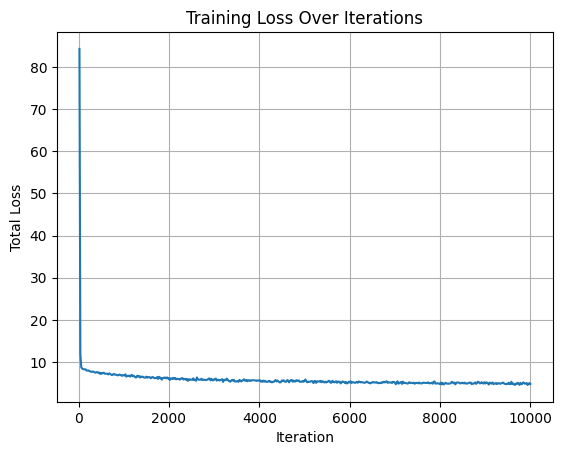

In [ ]:
import json
import matplotlib.pyplot as plt

metrics_path = "/content/deepfashion2_trousers_subset/output_trousers_keypoints/metrics.json"

losses = []
iterations = []

with open(metrics_path, 'r') as f:
    for line in f:
        try:
            data = json.loads(line)
            if "total_loss" in data:
                losses.append(data["total_loss"])
                iterations.append(data["iteration"])
        except:
            continue  # skip malformed lines if any

plt.plot(iterations, losses)
plt.title("Training Loss Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Total Loss")
plt.grid(True)
plt.show()

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
import numpy as np

# Reuse your cfg from training but make sure these are set:
cfg.DATASETS.TEST = ("trousers_val",)
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.KEYPOINT_ON = True
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 14

# Fix the OKS sigmas mismatch (14 keypoints instead of 17)
cfg.TEST.KEYPOINT_OKS_SIGMAS = np.ones(14).tolist()

# Create evaluator and loader
evaluator = COCOEvaluator("trousers_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "trousers_val")

# Run evaluation
predictor = DefaultPredictor(cfg)
results = inference_on_dataset(predictor.model, val_loader, evaluator)

print("Evaluation Results:\n", results)


WARNING [07/18 17:07:01 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[07/18 17:07:01 d2.data.datasets.coco]: Loaded 2206 images in COCO format from /content/deepfashion2_trousers_subset/Complete_Trousers_Dataset/coco_format/validation_coco.json
[07/18 17:07:01 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/18 17:07:01 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[07/18 17:07:01 d2.data.common]: Serializing 2206 elements to byte tensors and concatenating them all ...
[07/18 17:07:01 d2.data.common]: Serialized dataset takes 1.44 MiB
[07/18 17:07:03 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/deepfashion2_trousers_subset/output_trousers_keypoints_101/model_final.pth ...
[07/18

In [ ]:
!zip -r /content/output_trousers_keypoints_101.zip /content/deepfashion2_trousers_subset/output_trousers_keypoints_101

In [ ]:
!cp /content/output_trousers_keypoints_101.zip /content/drive/MyDrive/trainied_model